# Import libraries


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mlxtend.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale 
from sklearn import model_selection
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.cluster import KMeans
from sklearn.preprocessing import OneHotEncoder
from sklearn.utils import resample

# Data Import

In [3]:
dataset = pd.read_csv("Desktop/bankloan.csv")

##### Optional Drop Column

In [6]:
# Remove the column you want to drop
column_to_drop = "ID"  # Replace "column_name" with the name of the column you want to remove
dataset.drop(columns=[column_to_drop], inplace=True)
#column_to_drop = "vendor_id"  # Replace "column_name" with the name of the column you want to remove
#dataset.drop(columns=[column_to_drop], inplace=True)

# Data Cleaning

In [7]:
dataset.info()
#Distribution
dataset.describe().transpose()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Age                 5000 non-null   int64  
 1   Experience          5000 non-null   int64  
 2   Income              5000 non-null   int64  
 3   ZIP.Code            5000 non-null   int64  
 4   Family              5000 non-null   int64  
 5   CCAvg               5000 non-null   float64
 6   Education           5000 non-null   int64  
 7   Mortgage            5000 non-null   int64  
 8   Personal.Loan       5000 non-null   int64  
 9   Securities.Account  5000 non-null   int64  
 10  CD.Account          5000 non-null   int64  
 11  Online              5000 non-null   int64  
 12  CreditCard          5000 non-null   int64  
dtypes: float64(1), int64(12)
memory usage: 507.9 KB


,count,mean,std,min,25%,50%,75%,max
Age,5000.0,45.338400,11.463166,23.0,35.0,45.0,55.0,67.0
Experience,5000.0,20.104600,11.467954,-3.0,10.0,20.0,30.0,43.0
Income,5000.0,73.774200,46.033729,8.0,39.0,64.0,98.0,224.0
ZIP.Code,5000.0,93152.503000,2121.852197,9307.0,91911.0,93437.0,94608.0,96651.0
Family,5000.0,2.396400,1.147663,1.0,1.0,2.0,3.0,4.0
CCAvg,5000.0,1.937938,1.747659,0.0,0.7,1.5,2.5,10.0
Education,5000.0,1.881000,0.839869,1.0,1.0,2.0,3.0,3.0
Mortgage,5000.0,56.498800,101.713802,0.0,0.0,0.0,101.0,635.0
Personal.Loan,5000.0,0.096000,0.294621,0.0,0.0,0.0,0.0,1.0
Securities.Account,5000.0,0.104400,0.305809,0.0,0.0,0.0,0.0,1.0


### Null Values

In [8]:
dataset.isna().sum()

Age                   0
Experience            0
Income                0
ZIP.Code              0
Family                0
CCAvg                 0
Education             0
Mortgage              0
Personal.Loan         0
Securities.Account    0
CD.Account            0
Online                0
CreditCard            0
dtype: int64

In [9]:
# Calculate the threshold for missing values
threshold = 0.2 * len(dataset)

# Iterate over each column
for column in dataset.columns:
    # Check if the column has missing values
    if dataset[column].isna().sum() > 0:
        # If the column is numerical, fill missing values with column mean
        if dataset[column].dtype in ['int64', 'float64']:
            # If the number of missing values is less than the threshold, drop rows
            if dataset[column].isna().sum() < threshold:
                dataset = dataset.dropna(subset=[column])
            # If the number of missing values is greater than or equal to the threshold, fill with column mean
            else:
                column_mean = dataset[column].mean()
                dataset[column].fillna(column_mean, inplace=True)
        # If the column is categorical, drop rows with missing values
        elif dataset[column].dtype == 'object':
            # If the number of missing values is less than the threshold, drop rows
            if dataset[column].isna().sum() < threshold:
                dataset = dataset.dropna(subset=[column])

# Print modified dataset
print("Modified Dataset:")
if dataset.empty:
    print("No data available.")
else:
    print(dataset.head())

Modified Dataset:
   Age  Experience  Income  ZIP.Code  Family  CCAvg  Education  Mortgage  \
0   25           1      49     91107       4    1.6          1         0   
1   45          19      34     90089       3    1.5          1         0   
2   39          15      11     94720       1    1.0          1         0   
3   35           9     100     94112       1    2.7          2         0   
4   35           8      45     91330       4    1.0          2         0   

   Personal.Loan  Securities.Account  CD.Account  Online  CreditCard  
0              0                   1           0       0           0  
1              0                   1           0       0           0  
2              0                   0           0       0           0  
3              0                   0           0       0           0  
4              0                   0           0       0           1  


In [10]:
# Check for any remaining missing values
missing_values = dataset.isna().sum().sum()
if missing_values > 0:
    print("Warning: Dataset still contains missing values after cleaning.")


## Identify Target Variable

In [12]:
target = 'CreditCard'

# Feature Engineering 

In [13]:
# Convert the "sales" column to string type if it's not already
#dataset['sales'] = dataset['sales'].astype(str)

# Remove dollar signs and commas, and convert to integers
#dataset['sales'] = dataset['sales'].str.replace('$', '').str.replace(',', '', regex=False).astype(int)

### One Hot Encoder

In [14]:
# Check for categorical variables
categorical_columns = set()

# Add columns with less than 10 unique values
for column in dataset.columns:
    if column != target and dataset[column].nunique() < 10:
        categorical_columns.add(column)

# Append columns with object data type
categorical_columns.update(col for col in dataset.select_dtypes(include=['object']).columns.tolist() if col != target and col != target)

# Identify and add true/false columns
true_false_columns = [col for col in dataset.columns if dataset[col].dtype == 'bool']
categorical_columns.update(true_false_columns)

if len(categorical_columns) > 0:
    print("Categorical columns found:")
    for column in categorical_columns:
        print(column)
    
    # Fit the encoder to the categorical columns
    encoder = OneHotEncoder(drop='first', sparse_output=False)
    encoded_columns = encoder.fit_transform(dataset[list(categorical_columns)])

    # Get the feature names from the encoder
    encoded_feature_names = encoder.get_feature_names_out(input_features=list(categorical_columns))

    # Create a DataFrame with the encoded columns and feature names
    encoded_df = pd.DataFrame(encoded_columns, columns=encoded_feature_names, index=dataset.index)

    # Drop original categorical columns
    dataset.drop(columns=categorical_columns, inplace=True)
    
    # Concatenate encoded columns with dataset
    dataset = pd.concat([dataset, encoded_df], axis=1)
    
# Display the modified dataset
print("Modified Dataset:")
if dataset.empty:
    print("No data available.")
else:
    print(dataset.head())

Categorical columns found:
Personal.Loan
Online
Education
CD.Account
Securities.Account
Family
Modified Dataset:
   Age  Experience  Income  ZIP.Code  CCAvg  Mortgage  CreditCard  \
0   25           1      49     91107    1.6         0           0   
1   45          19      34     90089    1.5         0           0   
2   39          15      11     94720    1.0         0           0   
3   35           9     100     94112    2.7         0           0   
4   35           8      45     91330    1.0         0           1   

   Personal.Loan_1  Online_1  Education_2  Education_3  CD.Account_1  \
0              0.0       0.0          0.0          0.0           0.0   
1              0.0       0.0          0.0          0.0           0.0   
2              0.0       0.0          0.0          0.0           0.0   
3              0.0       0.0          1.0          0.0           0.0   
4              0.0       0.0          1.0          0.0           0.0   

   Securities.Account_1  Family_2  Fami

### Binary Variables

In [15]:
binary_variables = []

# Iterate through each column
for column in dataset.columns:
    # Check if the number of unique values is 2 and values are 0 and 1, or if the value is just 0
    if (dataset[column].nunique() == 2 and set(dataset[column]) == {0, 1}) or (dataset[column].nunique() == 1 and set(dataset[column]) == {0}):
        binary_variables.append(column)

# Print binary variables
print("Binary Variables:")
print(binary_variables)

Binary Variables:
['CreditCard', 'Personal.Loan_1', 'Online_1', 'Education_2', 'Education_3', 'CD.Account_1', 'Securities.Account_1', 'Family_2', 'Family_3', 'Family_4']


## Numerical to Binary Variables

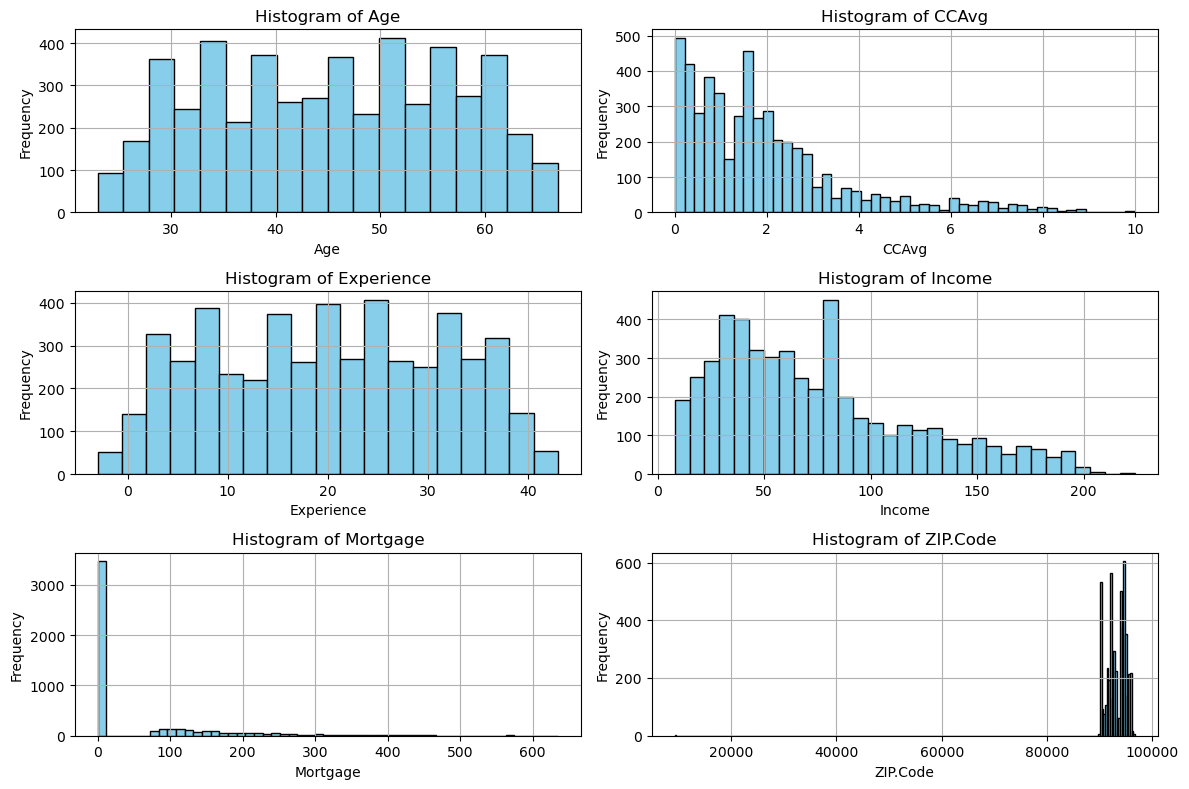

In [16]:
# Check if the target variable is numerical or categorical
if dataset[target].dtype in ['int64', 'float64']:
    # Get numerical variables excluding the target variable
    numerical_variables = dataset.select_dtypes(include=['int64', 'float64']).columns.drop(target)
else:
    # Get numerical variables excluding the target variable
    numerical_variables = dataset.select_dtypes(include=['int64', 'float64']).columns

numerical_variables = numerical_variables.difference(binary_variables)

# Calculate number of bins for each numerical variable
num_bins_dict = {}
for column in numerical_variables:
    # Calculate the number of bins using Freedman-Diaconis rule
    q75, q25 = dataset[column].quantile([0.75, 0.25])
    iqr = q75 - q25
    bin_width = 2 * iqr / (len(dataset[column]) ** (1/3))
    
    # Check if bin_width is zero
    if bin_width == 0:
        # Set a default number of bins or handle it appropriately
        num_bins = 10  # Default value
    else:
        num_bins = int((dataset[column].max() - dataset[column].min()) / bin_width)
        
    # Ensure num_bins is an integer value
    num_bins = int(num_bins)
    
    num_bins_dict[column] = num_bins

# Initialize an empty DataFrame to store the binned categorical variables
binned_dataset = pd.DataFrame()

# Calculate the number of rows and columns for subplots
num_variables = len(numerical_variables)
num_rows = int(np.ceil(num_variables / 2))
num_cols = 2

# Initialize figure for histograms
plt.figure(figsize=(12, 8))

# Iterate through each numerical variable
for i, column in enumerate(numerical_variables):
    plt.subplot(num_rows, num_cols, i + 1)
    
    # Plot histogram
    plt.hist(dataset[column], bins=num_bins_dict[column], color='skyblue', edgecolor='black')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.title(f'Histogram of {column}')
    plt.grid(True)
    
# Display the histograms
plt.tight_layout()
plt.show()


In [17]:
# Initialize an empty DataFrame to store the binned categorical variables
binned_dataset = pd.DataFrame()

# Iterate through each numerical variable
for column in numerical_variables:
    # Calculate the maximum number of bins for this column
    max_bins_column = num_bins_dict[column]
    
    # Bin the data accordingly
    bins, bin_edges = pd.cut(dataset[column], bins=max_bins_column, retbins=True)
    
    # Generate bin labels from the bin edges
    bin_labels = [f"{column}_{int(bin_edges[i])}_{int(bin_edges[i+1])}" for i in range(len(bin_edges)-1)]
    
    # Encode bins using one-hot encoding
    encoded_bins = pd.get_dummies(bins, prefix=column)
    
    # Rename columns with integer bin edges
    encoded_bins.columns = bin_labels
    
    # Concatenate encoded bins to the binned dataset
    binned_dataset = pd.concat([binned_dataset, encoded_bins], axis=1)

# Display the first few rows of the binned dataset
print("Binned Dataset:")
print(binned_dataset.head())



Binned Dataset:
   Age_22_25  Age_25_27  Age_27_30  Age_30_32  Age_32_35  Age_35_37  \
0          1          0          0          0          0          0   
1          0          0          0          0          0          0   
2          0          0          0          0          0          0   
3          0          0          0          0          1          0   
4          0          0          0          0          1          0   

   Age_37_40  Age_40_42  Age_42_45  Age_45_47  ...  ZIP.Code_93486_93802  \
0          0          0          0          0  ...                     0   
1          0          0          1          0  ...                     0   
2          1          0          0          0  ...                     0   
3          0          0          0          0  ...                     0   
4          0          0          0          0  ...                     0   

   ZIP.Code_93802_94119  ZIP.Code_94119_94435  ZIP.Code_94435_94752  \
0                     0      

In [18]:
# Check for duplicate column names
duplicate_columns = binned_dataset.columns[binned_dataset.columns.duplicated()]

# Print duplicate column names, if any
if len(duplicate_columns) > 0:
    print("Duplicate column names found:")
    for column in duplicate_columns:
        print(column)
    
    # Merge duplicate columns
    binned_dataset = binned_dataset.groupby(level=0, axis=1).sum()
    
    print("Duplicate columns merged.")
else:
    print("No duplicate column names found.")

Duplicate column names found:
CCAvg_0_0
CCAvg_0_0
CCAvg_0_0
CCAvg_1_1
CCAvg_1_1
CCAvg_1_1
CCAvg_2_2
CCAvg_2_2
CCAvg_2_2
CCAvg_3_3
CCAvg_3_3
CCAvg_4_4
CCAvg_4_4
CCAvg_4_4
CCAvg_5_5
CCAvg_5_5
CCAvg_5_5
CCAvg_6_6
CCAvg_6_6
CCAvg_7_7
CCAvg_7_7
CCAvg_7_7
CCAvg_8_8
CCAvg_8_8
CCAvg_8_8
CCAvg_9_9
CCAvg_9_9
Duplicate columns merged.


In [19]:
# Drop numerical columns from the original dataset
dataset.drop(columns=numerical_variables, inplace=True)

# Concatenate binned_dataset with the original dataset
dataset = pd.concat([dataset, binned_dataset], axis=1)

# Display the updated dataset
print("Updated Dataset:")
print(dataset.head())

Updated Dataset:
   CreditCard  Personal.Loan_1  Online_1  Education_2  Education_3  \
0           0              0.0       0.0          0.0          0.0   
1           0              0.0       0.0          0.0          0.0   
2           0              0.0       0.0          0.0          0.0   
3           0              0.0       0.0          1.0          0.0   
4           1              0.0       0.0          1.0          0.0   

   CD.Account_1  Securities.Account_1  Family_2  Family_3  Family_4  ...  \
0           0.0                   1.0       0.0       0.0       1.0  ...   
1           0.0                   1.0       0.0       1.0       0.0  ...   
2           0.0                   0.0       0.0       0.0       0.0  ...   
3           0.0                   0.0       0.0       0.0       0.0  ...   
4           0.0                   0.0       0.0       0.0       1.0  ...   

   ZIP.Code_94119_94435  ZIP.Code_94435_94752  ZIP.Code_94752_95068  \
0                     0           

In [20]:
# Check for any remaining missing values
missing_values = dataset.isna().sum().sum()
if missing_values > 0:
    print("Warning: Dataset still contains missing values after cleaning.")

### Up-Sampling

##### Outcome

In [21]:
dataset.groupby(target).count()

,Personal.Loan_1,Online_1,Education_2,Education_3,CD.Account_1,Securities.Account_1,Family_2,Family_3,Family_4,Age_22_25,...,ZIP.Code_94119_94435,ZIP.Code_94435_94752,ZIP.Code_94752_95068,ZIP.Code_95068_95385,ZIP.Code_95385_95701,ZIP.Code_95701_96018,ZIP.Code_96018_96334,ZIP.Code_9623_9939,ZIP.Code_96334_96651,ZIP.Code_9939_10256
CreditCard,,,,,,,,,,,,,,,,,,,,,
0,3530,3530,3530,3530,3530,3530,3530,3530,3530,3530,...,3530,3530,3530,3530,3530,3530,3530,3530,3530,3530
1,1470,1470,1470,1470,1470,1470,1470,1470,1470,1470,...,1470,1470,1470,1470,1470,1470,1470,1470,1470,1470


Target Value Counts (Sorted):
0    3530
1    1470
Name: CreditCard, dtype: int64


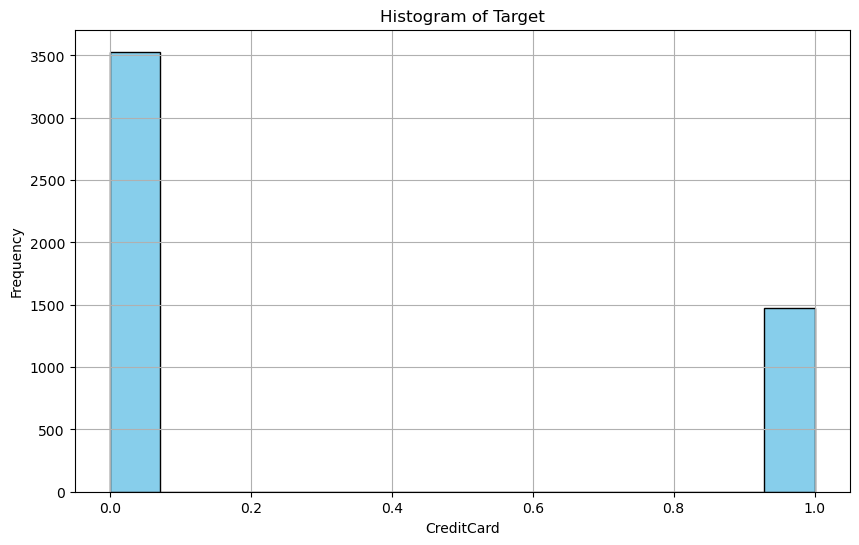

In [22]:
target_counts_sorted = dataset[target].value_counts().sort_index()

# Display the counts
print("Target Value Counts (Sorted):")
print(target_counts_sorted)

plt.figure(figsize=(10, 6))
plt.hist(dataset[target], bins='auto', color='skyblue', edgecolor='black')
plt.xlabel(target)
plt.ylabel('Frequency')
plt.title('Histogram of Target')
plt.grid(True)
plt.show()

In [23]:

df_majority = dataset[dataset[target] == 0]


df_minority = dataset[dataset[target] == 1]

# Upsample minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     
                                 n_samples=len(df_majority),
                                 random_state=42)  # Add random_state for reproducibility

# Combine minority class with majority class
dataset = pd.concat([df_majority, df_minority_upsampled])

# Check the value counts of the prediction column in the downsampled dataset
print(dataset[target].value_counts())


0    3530
1    3530
Name: CreditCard, dtype: int64


### Bias in other features

In [24]:
# Iterate over columns starting with "X"
for column in dataset.columns:
    if column.startswith("Personal"):
        # Get the target column
        upsamp_target = dataset[column]
        
        # Get the sorted value counts
        target_counts_sorted = upsamp_target.value_counts().sort_index()

        # Display the counts
        print(f"Target Value Counts for {column} (Sorted):")
        print(target_counts_sorted)

Target Value Counts for Personal.Loan_1 (Sorted):
0.0    6380
1.0     680
Name: Personal.Loan_1, dtype: int64


In [25]:
# Select rows where the value in the target column is equal to 1
df_majority = dataset[dataset["Personal.Loan_1"] == 0]


# Select rows where the value in the target column is equal to 0
df_minority = dataset[dataset["Personal.Loan_1"] == 1]

# Upsample minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     
                                 n_samples=1000,
                                 random_state=42)  # Add random_state for reproducibility

# Combine minority class with majority class
dataset = pd.concat([df_majority, df_minority_upsampled])

# Check the value counts of the prediction column in the downsampled dataset
print(dataset["Personal.Loan_1"].value_counts())

0.0    6380
1.0    1000
Name: Personal.Loan_1, dtype: int64


# Dimensionality Reduction

In [26]:
#Check for perfect multicollinearity
correlation_matrix = dataset.corr()
highly_correlated_variables = set()
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.8:
            colname_i = correlation_matrix.columns[i]
            colname_j = correlation_matrix.columns[j]
            highly_correlated_variables.add(colname_i)
            highly_correlated_variables.add(colname_j)
print("Highly correlated variables:", highly_correlated_variables)

# Step 2: Remove constant variables
constant_variables = [col for col in dataset.columns if dataset[col].nunique() == 1]
print("Constant variables:", constant_variables)
dataset.drop(columns=constant_variables, inplace=True)

# Define the target variable 'y'
y = dataset[target]

# Select all other columns as features 'x'
x = dataset.drop(columns=[target])

Highly correlated variables: set()
Constant variables: ['CCAvg_9_9', 'Income_210_217', 'Mortgage_11_23', 'Mortgage_23_35', 'Mortgage_35_47', 'Mortgage_47_59', 'Mortgage_59_71', 'ZIP.Code_10256_10572', 'ZIP.Code_10572_10889', 'ZIP.Code_10889_11205', 'ZIP.Code_11205_11522', 'ZIP.Code_11522_11838', 'ZIP.Code_11838_12155', 'ZIP.Code_12155_12471', 'ZIP.Code_12471_12788', 'ZIP.Code_12788_13104', 'ZIP.Code_13104_13421', 'ZIP.Code_13421_13737', 'ZIP.Code_13737_14053', 'ZIP.Code_14053_14370', 'ZIP.Code_14370_14686', 'ZIP.Code_14686_15003', 'ZIP.Code_15003_15319', 'ZIP.Code_15319_15636', 'ZIP.Code_15636_15952', 'ZIP.Code_15952_16269', 'ZIP.Code_16269_16585', 'ZIP.Code_16585_16902', 'ZIP.Code_16902_17218', 'ZIP.Code_17218_17535', 'ZIP.Code_17535_17851', 'ZIP.Code_17851_18167', 'ZIP.Code_18167_18484', 'ZIP.Code_18484_18800', 'ZIP.Code_18800_19117', 'ZIP.Code_19117_19433', 'ZIP.Code_19433_19750', 'ZIP.Code_19750_20066', 'ZIP.Code_20066_20383', 'ZIP.Code_20383_20699', 'ZIP.Code_20699_21016', 'ZIP.Co

### Outlier Detection

#### **Data is scaled in this step***

In [27]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Perform KMeans clustering
# Separate features (X) and target variable (y) if necessary
X = dataset.drop(columns=[target])
y = dataset[target]

# Scale the features (X)
scaler = StandardScaler()
scaled_X = scaler.fit_transform(X)

kmeans = KMeans()
kmeans.fit(scaled_X)

# Get cluster centers
centers = kmeans.cluster_centers_

# Calculate distances of each point to its respective cluster center
distances = np.sqrt(np.sum((scaled_X - centers[kmeans.labels_])**2, axis=1))

# Calculate mean and standard deviation of distances
mean_distance = np.mean(distances)
std_distance = np.std(distances)

# Desired threshold as 2 standard deviations from the mean
desired_threshold = mean_distance + 2 * std_distance

# Use the threshold for outlier detection
outliers_mask = distances > desired_threshold

# Save outliers in a new dataset
outliers_dataset = dataset[outliers_mask]

# Print indices and details of outliers
print("Indices of outliers:", np.where(outliers_mask)[0])
print("Details of outliers:")
print(outliers_dataset)

# Remove outliers from the original dataset
dataset = dataset[~outliers_mask]

Indices of outliers: [  38   84  208  217  225  294  370  413  426  430  432  434  481  655
  711  739  742  755  774  810  817  860  864  906  937  959 1018 1031
 1035 1066 1072 1088 1130 1186 1318 1458 1482 1523 1541 1590 1592 1694
 1708 1722 1751 1777 1881 1885 1886 1889 1913 1914 1925 1930 1931 1961
 2034 2058 2136 2244 2252 2301 2308 2335 2515 2628 2703 2714 2716 2746
 2901 2989 3187 3198 3214 3292 3397 3436 3486 3515 3524 3554 3619 3671
 3733 3907 4029 4044 4115 4177 4460 4478 4566 4606 4705 4773 4798 4837
 4922 4948 4962 4970 5192 5220 5240 5263 5273 5325 5399 5660 5865 5903
 5914 5919 6114 6347 6369 6378 6380 6385 6393 6399 6402 6406 6410 6417
 6422 6423 6427 6429 6451 6452 6459 6470 6488 6495 6499 6504 6547 6565
 6597 6599 6600 6607 6612 6619 6622 6629 6638 6655 6664 6668 6672 6688
 6698 6699 6701 6710 6713 6726 6729 6733 6734 6747 6752 6764 6765 6774
 6776 6778 6793 6794 6796 6801 6802 6804 6830 6848 6875 6883 6889 6893
 6896 6899 6909 6949 6953 6955 6969 6984 7008 7012 7020 

In [28]:
X = dataset.drop(columns=[target])
y = dataset[target]

### Principal Component Analysis (PCA)

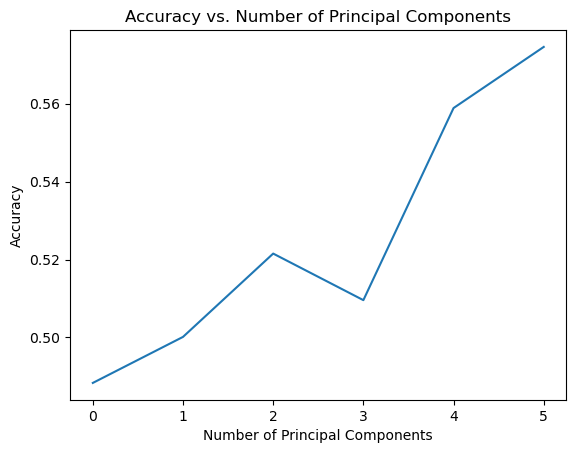

In [30]:
from sklearn.model_selection import RepeatedKFold, cross_val_score
from sklearn.decomposition import PCA
from sklearn.svm import SVC
import matplotlib.pyplot as plt

# Perform PCA
pca = PCA()
x_reduced = pca.fit_transform(X)

# Define cross-validation method
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

svc = SVC()

# Calculate accuracy with only the intercept
accuracy = []
score = cross_val_score(svc, np.ones((len(x_reduced), 1)), y, cv=cv, scoring='accuracy').mean()
accuracy.append(score)

# Calculate accuracy using cross-validation, adding one component at a time
for i in range(1, 6):
    score = cross_val_score(svc, x_reduced[:, :i], y, cv=cv, scoring='accuracy').mean()
    accuracy.append(score)

# Plot cross-validation results
plt.plot(accuracy)
plt.xlabel('Number of Principal Components')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Number of Principal Components')
plt.show()


In [31]:
#percentage of variance in the response variable explained by adding in each principal component to the model:
np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)

array([  4.74,   9.06,  12.98,  16.8 ,  20.36,  23.67,  26.67,  29.14,
        31.35,  33.47,  35.58,  37.56,  39.51,  41.39,  43.23,  45.01,
        46.67,  48.33,  49.92,  51.36,  52.78,  54.13,  55.44,  56.7 ,
        57.95,  59.16,  60.35,  61.51,  62.63,  63.73,  64.8 ,  65.85,
        66.86,  67.85,  68.81,  69.76,  70.67,  71.56,  72.41,  73.24,
        74.05,  74.84,  75.63,  76.39,  77.12,  77.83,  78.52,  79.2 ,
        79.85,  80.5 ,  81.13,  81.73,  82.32,  82.9 ,  83.47,  84.02,
        84.54,  85.04,  85.53,  86.  ,  86.46,  86.9 ,  87.32,  87.74,
        88.16,  88.56,  88.95,  89.33,  89.7 ,  90.05,  90.4 ,  90.74,
        91.07,  91.4 ,  91.72,  92.03,  92.33,  92.63,  92.92,  93.2 ,
        93.48,  93.74,  94.  ,  94.26,  94.51,  94.76,  95.  ,  95.23,
        95.46,  95.69,  95.91,  96.12,  96.33,  96.52,  96.71,  96.89,
        97.07,  97.24,  97.41,  97.58,  97.74,  97.89,  98.04,  98.19,
        98.33,  98.47,  98.6 ,  98.72,  98.83,  98.93,  99.03,  99.13,
      

In [32]:
# Choose the desired number of principal components based on the plot
num_components = 112 # For example, choose n principal components

# Use the selected number of principal components
x_reduced_selected = x_reduced[:, :num_components]

# Splitting the dataset

In [33]:
from sklearn.model_selection import train_test_split


# Split the data into training (50%), testing (30%), and out-of-sample (20%)
x_train, x_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=100)
x_test, x_out_sample, y_test, y_out_sample = train_test_split(x_temp, y_temp, test_size=0.6, random_state=100)

In [34]:
missing_values = dataset.isnull().sum().sum()
if missing_values > 0:
    print("Warning: Dataset still contains missing values after cleaning.")


# Fitting the SVM model

In [35]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import SVC
from scipy.stats import randint

# Define the parameter distributions
param_dist = {
    'C': [0.1, 1, 10, 100],  # Penalty parameter C of the error term
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],  # Kernel type
    'gamma': ['scale', 'auto'],  # Kernel coefficient for 'rbf', 'poly' and 'sigmoid'
}

# Create an SVM classifier
svc = SVC()

# Use random search to find the best hyperparameters
rand_search = RandomizedSearchCV(svc, 
                                 param_distributions=param_dist, 
                                 n_iter=10,  # Number of parameter settings that are sampled
                                 cv=4)       # Cross-validation folds

# Fit the random search object to the data
rand_search.fit(x_train, y_train)

# Print best parameters found
print("Best Parameters:", rand_search.best_params_)

# Print best mean cross-validated score found
print("Train Score:", rand_search.best_score_)

# Evaluate the best model on the test set
print("Test Score:", rand_search.score(x_test, y_test))

Best Parameters: {'kernel': 'rbf', 'gamma': 'scale', 'C': 100}
Train Score: 0.7829131652661064
Test Score: 0.8152364273204904


In [36]:
# Define the Support Vector Classifier (SVC) with specified hyperparameters
svc = SVC(kernel='rbf', C=100, gamma='scale', random_state=100)

# Fit the training data to the SVC
svc.fit(x_train, y_train)

SVC(C=100, random_state=100)

In [37]:
y_pred = svc.predict(x_test)
y_pred

array([1, 0, 1, ..., 0, 0, 1])

In [38]:
from sklearn.metrics import accuracy_score

print("SVM accuracy is %2.2f" % accuracy_score( 
     y_test, svc.predict(x_test)))

SVM accuracy is 0.82


# Model Evaluation

### On test data

In [39]:
from sklearn import metrics

# Predict the labels for the test set
y_pred = svc.predict(x_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred) * 100

# Print accuracy
print('Accuracy: {:.2f}%'.format(accuracy))

Accuracy: 81.52%


In [40]:
from sklearn.metrics import balanced_accuracy_score

# Assuming y_true and y_pred are your true and predicted labels, respectively
balanced_accuracy = balanced_accuracy_score(y_test, y_pred)* 100

print('Balanced Accuracy Score: {:.2f}%'.format(balanced_accuracy))

Balanced Accuracy Score: 81.42%


In [77]:
from sklearn.metrics import jaccard_score
jaccard_score(y_test, y_pred)

0.7040673211781207

### On out-of-sample data

In [42]:
# Predict the labels for the out-of-sample set
y_pred_out_sample = svc.predict(x_out_sample)

# Calculate accuracy
accuracy_out_sample = accuracy_score(y_out_sample, y_pred_out_sample) * 100

# Print accuracy
print('Accuracy: {:.2f}%'.format(accuracy_out_sample))


Accuracy: 79.17%


In [43]:
balanced_accuracy = balanced_accuracy_score(y_out_sample, y_pred_out_sample)*100

print('Balanced Accuracy Score: {:.2f}%'.format(balanced_accuracy))

Balanced Accuracy Score: 79.18%


In [78]:
from sklearn.metrics import jaccard_score
jaccard_score(y_out_sample, y_pred_out_sample)

0.669750231267345

# Confusion Matrix

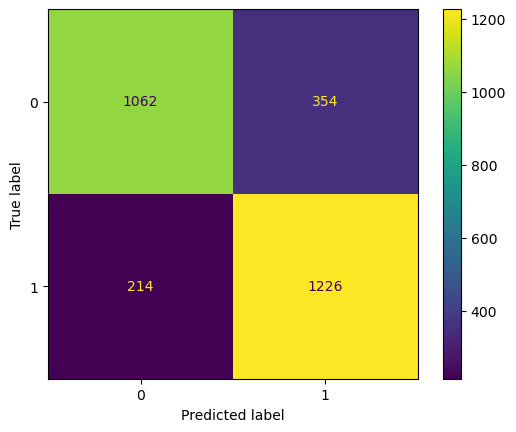

In [45]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# Create the confusion matrix
# Compute confusion matrices
cm_test = confusion_matrix(y_test, y_pred)
cm_out_sample = confusion_matrix(y_out_sample, y_pred_out_sample)

# Combine the confusion matrices
cm = cm_test + cm_out_sample

ConfusionMatrixDisplay(confusion_matrix=cm).plot();

In [46]:
# Extract indices of false positives and false negatives from the confusion matrix
false_positive_indices = [(i, j) for i in range(cm.shape[0]) for j in range(cm.shape[1]) if i != j and j == 1]  # False positive indices
false_negative_indices = [(i, j) for i in range(cm.shape[0]) for j in range(cm.shape[1]) if i != j and j == 0]  # False negative indices

# Create new DataFrame to store instances with correct and incorrect predictions
correct_rows = []
incorrect_rows = []

for index, (true_label, pred_label, out_true_label, out_pred_label) in enumerate(zip(y_test, y_pred, y_out_sample, y_pred_out_sample)):
    # Check for false positives or false negatives in the first set of predictions
    if (true_label, pred_label) in false_positive_indices or (true_label, pred_label) in false_negative_indices:
        row_data = dataset.iloc[index].tolist()
        incorrect_rows.append(row_data + [False])
    else:
        row_data = dataset.iloc[index].tolist()
        correct_rows.append(row_data + [True])

# Process remaining instances in the second set of predictions
for index, (out_true_label, out_pred_label) in enumerate(zip(y_out_sample, y_pred_out_sample)):
    # Check for false positives or false negatives in the second set of predictions
    if (out_true_label, out_pred_label) in false_positive_indices or (out_true_label, out_pred_label) in false_negative_indices:
        row_data = dataset.iloc[len(y_test) + index].tolist()  # Adjust index to start from where the first loop left off
        incorrect_rows.append(row_data + [False])
    else:
        row_data = dataset.iloc[len(y_test) + index].tolist()  # Adjust index to start from where the first loop left off
        correct_rows.append(row_data + [True])

# Create DataFrames from the collected rows
correct_df = pd.DataFrame(correct_rows, columns=dataset.columns.tolist() + ['correct'])
incorrect_df = pd.DataFrame(incorrect_rows, columns=dataset.columns.tolist() + ['correct'])

# Combine correct_df and incorrect_df into a single DataFrame
result_dataset = pd.concat([correct_df, incorrect_df], ignore_index=True)

# Print the resulting dataset
print(result_dataset)

      CreditCard  Personal.Loan_1  Online_1  Education_2  Education_3  \
0            0.0              0.0       0.0          0.0          0.0   
1            0.0              0.0       0.0          0.0          0.0   
2            0.0              0.0       0.0          1.0          0.0   
3            0.0              0.0       1.0          1.0          0.0   
4            0.0              0.0       1.0          1.0          0.0   
...          ...              ...       ...          ...          ...   
2851         0.0              0.0       1.0          0.0          0.0   
2852         0.0              0.0       1.0          0.0          0.0   
2853         0.0              0.0       1.0          0.0          0.0   
2854         0.0              0.0       0.0          0.0          1.0   
2855         0.0              0.0       0.0          0.0          1.0   

      CD.Account_1  Securities.Account_1  Family_2  Family_3  Family_4  ...  \
0              0.0                   1.0    

In [47]:
# Count the number of correct predictions
correct_count = result_dataset[result_dataset['correct'] == True].shape[0]
print (correct_count)

2288


### Fairness Test

use this when theres multiple columns youre looking over (ex. age_10_15...age 40_50.. etc)

In [48]:
# Initialize dictionary to store error rates
error_rates = {}

# Iterate over columns in the dataset
for column in result_dataset.columns:
    # Check if the column name starts with "salary"
    if column.startswith('Age'):
        # Filter rows where the current salary column equals 1
        salary_rows = result_dataset[result_dataset[column] == 1]
        # Calculate error rate for the current salary column
        error_rate = 1 - salary_rows['correct'].mean()
        # Store error rate in the dictionary
        error_rates[column] = error_rate

# Print error rates for each salary column
for column, error_rate in error_rates.items():
    print(f"Error rate for rows where {column} = 1 in result_dataset:", error_rate)


Error rate for rows where Age_22_25 = 1 in result_dataset: 0.17460317460317465
Error rate for rows where Age_25_27 = 1 in result_dataset: 0.17582417582417587
Error rate for rows where Age_27_30 = 1 in result_dataset: 0.19499999999999995
Error rate for rows where Age_30_32 = 1 in result_dataset: 0.16666666666666663
Error rate for rows where Age_32_35 = 1 in result_dataset: 0.19650655021834063
Error rate for rows where Age_35_37 = 1 in result_dataset: 0.24528301886792447
Error rate for rows where Age_37_40 = 1 in result_dataset: 0.24472573839662448
Error rate for rows where Age_40_42 = 1 in result_dataset: 0.2407407407407407
Error rate for rows where Age_42_45 = 1 in result_dataset: 0.14932126696832582
Error rate for rows where Age_45_47 = 1 in result_dataset: 0.19841269841269837
Error rate for rows where Age_47_49 = 1 in result_dataset: 0.24444444444444446
Error rate for rows where Age_49_52 = 1 in result_dataset: 0.19313304721030045
Error rate for rows where Age_52_54 = 1 in result_dat

use when looking over one column (ex. Sex_Male)

In [ ]:
# Initialize dictionaries to store error rates
error_rates_1 = {}
error_rates_0 = {}

# Iterate over columns in the dataset
for column in result_dataset.columns:
    # Check if the column name starts with "Sex"
    if column.startswith('Sex'):
        # Filter rows where the current column equals 1
        rows_1 = result_dataset[result_dataset[column] == 1]
        # Calculate error rate for the current column when equal to 1
        error_rate_1 = 1 - rows_1['correct'].mean()
        # Store error rate in the dictionary
        error_rates_1[column] = error_rate_1

        # Filter rows where the current column equals 0
        rows_0 = result_dataset[result_dataset[column] == 0]
        # Calculate error rate for the current column when equal to 0
        error_rate_0 = 1 - rows_0['correct'].mean()
        # Store error rate in the dictionary
        error_rates_0[column] = error_rate_0

# Print error rates for each column where equal to 1
print("Error rates for rows where the column equals 1 in result_dataset:")
for column, error_rate in error_rates_1.items():
    print(f"Error rate for {column}: {error_rate}")

# Print error rates for each column where equal to 0
print("\nError rates for rows where the column equals 0 in result_dataset:")
for column, error_rate in error_rates_0.items():
    print(f"Error rate for {column}: {error_rate}")


# ROC Curve

for binary classification

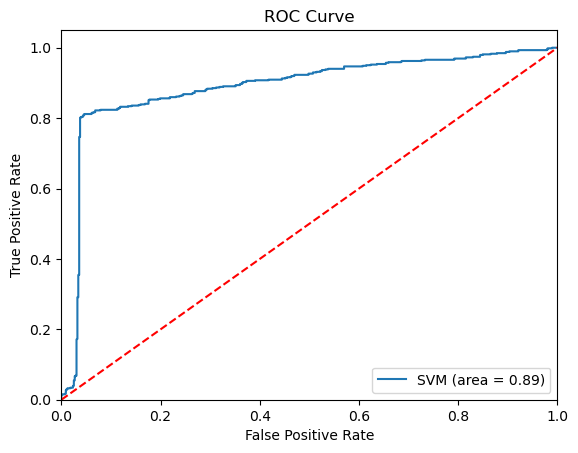

In [49]:
from sklearn.metrics import roc_curve, auc

#Predict probabilities on the test set
y_pred_decision = svc.decision_function(x_test)

# Calculate the false positive rate (FPR), true positive rate (TPR), and thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_decision)

# Calculate the area under the ROC curve (AUC)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, label='SVM (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

# Outlier Model

### Up-Sampling

Target Value Counts (Sorted):
0    129
1    111
Name: CreditCard, dtype: int64


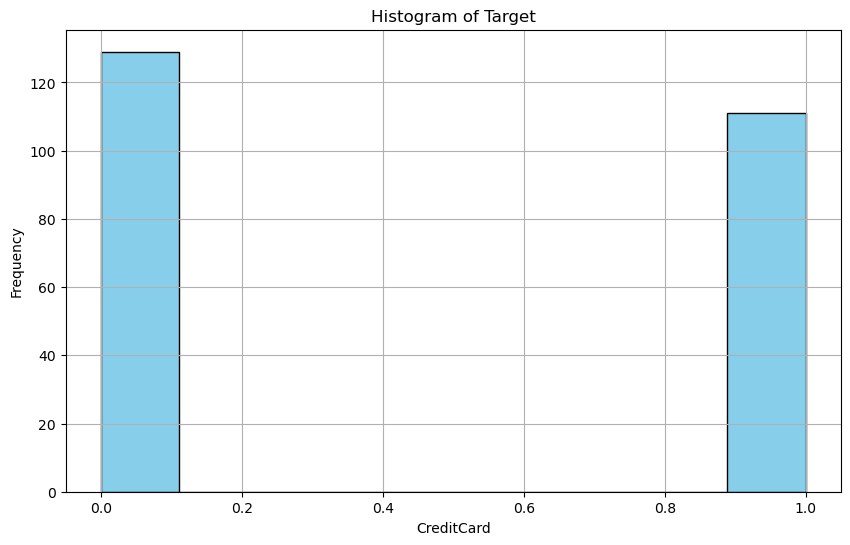

In [51]:
target_counts_sorted = outliers_dataset[target].value_counts().sort_index()

# Display the counts
print("Target Value Counts (Sorted):")
print(target_counts_sorted)

plt.figure(figsize=(10, 6))
plt.hist(outliers_dataset[target], bins='auto', color='skyblue', edgecolor='black')
plt.xlabel(target)
plt.ylabel('Frequency')
plt.title('Histogram of Target')
plt.grid(True)
plt.show()

In [52]:
df_majority = outliers_dataset[outliers_dataset[target] == 0]


df_minority = outliers_dataset[outliers_dataset[target] == 1]

# Upsample minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     
                                 n_samples=len(df_majority),
                                 random_state=42)  # Add random_state for reproducibility

# Combine minority class with majority class
outliers_dataset = pd.concat([df_majority, df_minority_upsampled])

# Check the value counts of the prediction column in the downsampled dataset
print(outliers_dataset[target].value_counts())


0    129
1    129
Name: CreditCard, dtype: int64


In [53]:
# Define the target variable 'y'
oy = outliers_dataset[target]

# Select all other columns as features 'x'
ox = outliers_dataset.drop(columns=[target])

### PCA

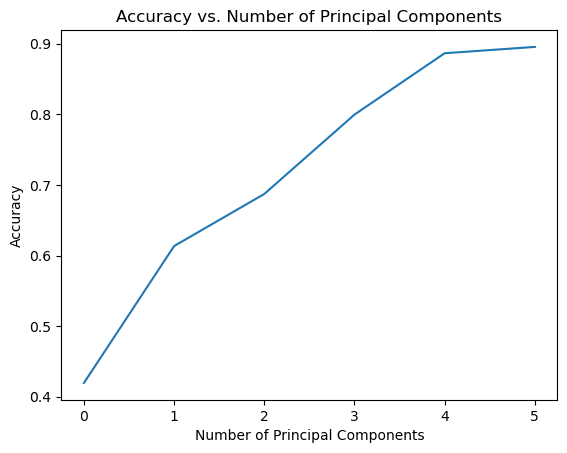

In [56]:
from sklearn.model_selection import RepeatedKFold, cross_val_score
from sklearn.decomposition import PCA
from sklearn.svm import SVC
import matplotlib.pyplot as plt

# Perform PCA
pca = PCA()
ox_reduced = pca.fit_transform(ox)

# Define cross-validation method
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

svc = SVC()

# Calculate accuracy with only the intercept
accuracy = []
score = cross_val_score(svc, np.ones((len(ox_reduced), 1)), oy, cv=cv, scoring='accuracy').mean()
accuracy.append(score)

# Calculate accuracy using cross-validation, adding one component at a time
for i in range(1, 6):
    score = cross_val_score(svc, ox_reduced[:, :i], oy, cv=cv, scoring='accuracy').mean()
    accuracy.append(score)

# Plot cross-validation results
plt.plot(accuracy)
plt.xlabel('Number of Principal Components')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Number of Principal Components')
plt.show()


In [57]:
#percentage of variance in the response variable explained by adding in each principal component to the model:
np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)

array([ 9.05, 15.71, 22.02, 27.53, 31.8 , 35.55, 39.  , 42.29, 45.37,
       48.26, 50.63, 52.88, 54.97, 56.87, 58.76, 60.57, 62.3 , 63.91,
       65.37, 66.76, 68.11, 69.41, 70.66, 71.88, 73.08, 74.21, 75.32,
       76.37, 77.39, 78.39, 79.33, 80.21, 81.06, 81.86, 82.62, 83.36,
       84.07, 84.77, 85.45, 86.07, 86.68, 87.25, 87.79, 88.33, 88.85,
       89.34, 89.82, 90.29, 90.73, 91.16, 91.55, 91.94, 92.3 , 92.65,
       92.99, 93.33, 93.65, 93.96, 94.26, 94.55, 94.83, 95.08, 95.32,
       95.55, 95.78, 96.  , 96.21, 96.41, 96.6 , 96.78, 96.95, 97.12,
       97.28, 97.43, 97.58, 97.72, 97.86, 97.98, 98.1 , 98.22, 98.33,
       98.44, 98.54, 98.64, 98.73, 98.82, 98.9 , 98.98, 99.05, 99.12,
       99.19, 99.25, 99.31, 99.36, 99.41, 99.46, 99.51, 99.55, 99.59,
       99.63, 99.66, 99.69, 99.72, 99.75, 99.77, 99.79, 99.81, 99.83,
       99.85, 99.86, 99.87, 99.88, 99.89, 99.9 , 99.91, 99.92, 99.93,
       99.93, 99.93, 99.93, 99.93, 99.93, 99.93, 99.93, 99.93, 99.93,
       99.93, 99.93,

In [58]:
# Choose the desired number of principal components based on the plot
num_components = 90 # For example, choose n principal components

# Use the selected number of principal components
ox_reduced_selected = ox_reduced[:, :num_components]

## Spliting the Outlier dataset

In [59]:
from sklearn.model_selection import train_test_split


# Split the data into training (50%), testing (30%), and out-of-sample (20%)
ox_train, ox_temp, oy_train, oy_temp = train_test_split(ox, oy, test_size=0.4, random_state=100)
ox_test, ox_out_sample, oy_test, oy_out_sample = train_test_split(ox_temp, oy_temp, test_size=0.6, random_state=100)

In [60]:
missing_values = outliers_dataset.isnull().sum().sum()
if missing_values > 0:
    print("Warning: Dataset still contains missing values after cleaning.")


## Fitting the SVM model

In [61]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import SVC
from scipy.stats import randint

# Define the parameter distributions
param_dist = {
    'C': [0.1, 1, 10, 100],  # Penalty parameter C of the error term
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],  # Kernel type
    'gamma': ['scale', 'auto'],  # Kernel coefficient for 'rbf', 'poly' and 'sigmoid'
}

# Create an SVM classifier
svc = SVC()

# Use random search to find the best hyperparameters
rand_search = RandomizedSearchCV(svc, 
                                 param_distributions=param_dist, 
                                 n_iter=10,  # Number of parameter settings that are sampled
                                 cv=4)       # Cross-validation folds

# Fit the random search object to the data
rand_search.fit(ox_train, oy_train)

# Print best parameters found
print("Best Parameters:", rand_search.best_params_)

# Print best mean cross-validated score found
print("Train Score:", rand_search.best_score_)

# Evaluate the best model on the test set
print("Test Score:", rand_search.score(ox_test, oy_test))

Best Parameters: {'kernel': 'rbf', 'gamma': 'scale', 'C': 10}
Train Score: 0.9154858299595142
Test Score: 0.975609756097561


In [62]:
# Define the Support Vector Classifier (SVC) with specified hyperparameters
svc = SVC(kernel='rbf', C=10, gamma='scale', random_state=100)

# Fit the training data to the SVC
svc.fit(ox_train, oy_train)

SVC(C=10, random_state=100)

In [63]:
oy_pred = svc.predict(ox_test)
oy_pred

array([0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1,
       0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1])

In [64]:
print("SVM accuracy is %2.2f" % accuracy_score( 
     oy_test, svc.predict(ox_test)))

SVM accuracy is 0.98


## Model Evaluation

### On test data

In [65]:
from sklearn import metrics
# Predict the labels for the test set
oy_pred = svc.predict(ox_test)

# Calculate accuracy
oaccuracy = accuracy_score(oy_test, oy_pred) * 100

# Print accuracy
print('Accuracy: {:.2f}%'.format(oaccuracy))

Accuracy: 97.56%


In [66]:
from sklearn.metrics import balanced_accuracy_score

# Assuming y_true and y_pred are your true and predicted labels, respectively
balanced_accuracy = balanced_accuracy_score(oy_test, oy_pred)* 100

print('Balanced Accuracy Score: {:.2f}%'.format(balanced_accuracy))

Balanced Accuracy Score: 97.73%


In [67]:
from sklearn.metrics import jaccard_score
jaccard_score(oy_test, oy_pred)

0.9545454545454546

### On out-of-sample data

In [68]:
from sklearn.metrics import accuracy_score

# Predict the labels for the out-of-sample set
oy_pred_out_sample = svc.predict(ox_out_sample)

# Calculate accuracy
oaccuracy_out_sample = accuracy_score(oy_out_sample, oy_pred_out_sample) * 100

# Print accuracy
print('Accuracy: {:.2f}%'.format(oaccuracy_out_sample))

Accuracy: 98.41%


In [69]:
from sklearn.metrics import balanced_accuracy_score

# Assuming y_true and y_pred are your true and predicted labels, respectively
balanced_accuracy = balanced_accuracy_score(oy_out_sample, oy_pred_out_sample)* 100

print('Balanced Accuracy Score: {:.2f}%'.format(balanced_accuracy))

Balanced Accuracy Score: 98.33%


In [70]:
from sklearn.metrics import jaccard_score
jaccard_score(oy_out_sample, oy_pred_out_sample)

0.9666666666666667

## Confusion Matrix

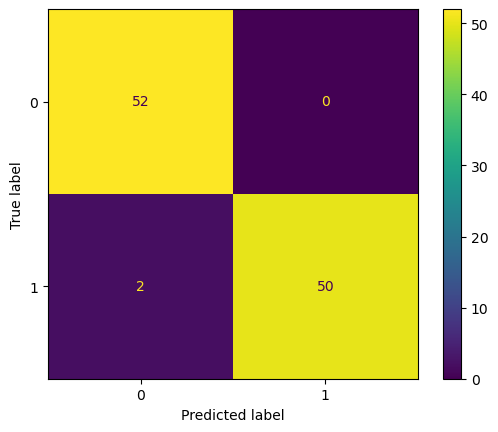

In [71]:
# Create the confusion matrix

ocm_test = confusion_matrix(oy_test, oy_pred)
ocm_out_sample = confusion_matrix(oy_out_sample, oy_pred_out_sample)

# Combine the confusion matrices
ocm = ocm_test + ocm_out_sample

# Plot the confusion matrix
ConfusionMatrixDisplay(confusion_matrix=ocm).plot()


In [72]:
false_positive_indices = [(i, j) for i in range(ocm.shape[0]) for j in range(ocm.shape[1]) if i != j and j == 1]  # False positive indices
false_negative_indices = [(i, j) for i in range(ocm.shape[0]) for j in range(ocm.shape[1]) if i != j and j == 0]  # False negative indices

# Create new DataFrame to store instances with correct and incorrect predictions
ocorrect_rows = []
oincorrect_rows = []

for index, (true_label, pred_label, out_true_label, out_pred_label) in enumerate(zip(oy_test, oy_pred, oy_out_sample, oy_pred_out_sample)):
    # Check for false positives or false negatives in the first set of predictions
    if (true_label, pred_label) in false_positive_indices or (true_label, pred_label) in false_negative_indices:
        row_data = outliers_dataset.iloc[index].tolist()
        oincorrect_rows.append(row_data + [False])
    else:
        row_data = outliers_dataset.iloc[index].tolist()
        ocorrect_rows.append(row_data + [True])

# Process remaining instances in the second set of predictions
for index, (out_true_label, out_pred_label) in enumerate(zip(oy_out_sample, oy_pred_out_sample)):
    # Check for false positives or false negatives in the second set of predictions
    if (out_true_label, out_pred_label) in false_positive_indices or (out_true_label, out_pred_label) in false_negative_indices:
        row_data = outliers_dataset.iloc[len(oy_test) + index].tolist()  # Adjust index to start from where the first loop left off
        oincorrect_rows.append(row_data + [False])
    else:
        row_data = outliers_dataset.iloc[len(oy_test) + index].tolist()  # Adjust index to start from where the first loop left off
        ocorrect_rows.append(row_data + [True])

# Create DataFrames from the collected rows
ocorrect_df = pd.DataFrame(ocorrect_rows, columns=outliers_dataset.columns.tolist() + ['correct'])
oincorrect_df = pd.DataFrame(oincorrect_rows, columns=outliers_dataset.columns.tolist() + ['correct'])

# Combine correct_df and incorrect_df into a single DataFrame
oresult_dataset = pd.concat([ocorrect_df, oincorrect_df], ignore_index=True)

# Print the resulting dataset
print(oresult_dataset)

     CreditCard  Personal.Loan_1  Online_1  Education_2  Education_3  \
0           0.0              0.0       0.0          0.0          0.0   
1           0.0              0.0       0.0          0.0          0.0   
2           0.0              0.0       1.0          0.0          0.0   
3           0.0              0.0       0.0          0.0          0.0   
4           0.0              0.0       1.0          0.0          0.0   
..          ...              ...       ...          ...          ...   
99          0.0              1.0       0.0          0.0          1.0   
100         0.0              1.0       1.0          0.0          0.0   
101         0.0              1.0       0.0          1.0          0.0   
102         0.0              0.0       0.0          0.0          0.0   
103         0.0              1.0       1.0          1.0          0.0   

     CD.Account_1  Securities.Account_1  Family_2  Family_3  Family_4  ...  \
0             0.0                   0.0       1.0       0

## ROC Curve

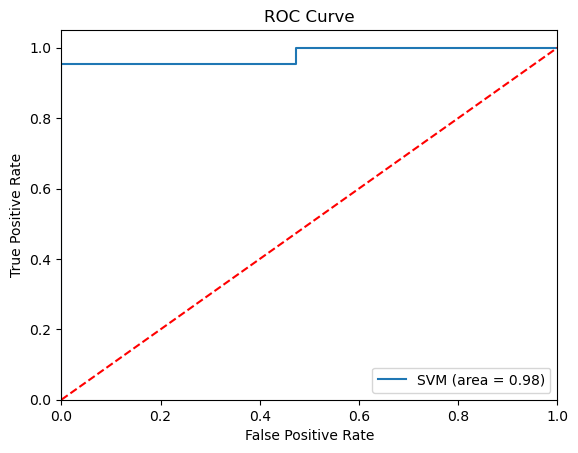

In [74]:
#Predict probabilities on the test set
oy_pred_decision = svc.decision_function(ox_test)

# Calculate the false positive rate (FPR), true positive rate (TPR), and thresholds
fpr, tpr, thresholds = roc_curve(oy_test, oy_pred_decision)

# Calculate the area under the ROC curve (AUC)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, label='SVM (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

# Combined Model

In [75]:
combined_data = pd.concat([oresult_dataset, result_dataset], axis=0)

# Reset index after concatenation
combined_data.reset_index(drop=True, inplace=True)

# Display the combined dataset
print(combined_data)

      CreditCard  Personal.Loan_1  Online_1  Education_2  Education_3  \
0            0.0              0.0       0.0          0.0          0.0   
1            0.0              0.0       0.0          0.0          0.0   
2            0.0              0.0       1.0          0.0          0.0   
3            0.0              0.0       0.0          0.0          0.0   
4            0.0              0.0       1.0          0.0          0.0   
...          ...              ...       ...          ...          ...   
2955         0.0              0.0       1.0          0.0          0.0   
2956         0.0              0.0       1.0          0.0          0.0   
2957         0.0              0.0       1.0          0.0          0.0   
2958         0.0              0.0       0.0          0.0          1.0   
2959         0.0              0.0       0.0          0.0          1.0   

      CD.Account_1  Securities.Account_1  Family_2  Family_3  Family_4  ...  \
0              0.0                   0.0    

In [76]:
# Calculate accuracy
accuracy = combined_data['correct'].mean() * 100  # Convert to percentage

# Display accuracy
print("Accuracy:", accuracy, "%")

Accuracy: 80.74324324324324 %
